# Neural Network Classifier & Regressor

In this tutorial we show how the `NeuralNetworkClassifier` and `NeuralNetworkRegressor` are used.
Both take as an input a (Quantum) `NeuralNetwork` and leverage it in a specific context.
In both cases we also provide a pre-configured variant for convenience, the Variational Quantum Classifier (`VQC`) and Variational Quantum Regressor (`VQR`). The tutorial is structured as follows:


1. [Classification](#Classification) 
    * Classification with an `OpflowQNN`
    * Classification with a `CircuitQNN`
    * Variational Quantum Classifier (`VQC`)
    
    
2. [Regression](#Regression)
    * Regression with an `OpflowQNN`
    * Variational Quantum Regressor (`VQR`)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor

from typing import Union
from qiskit.algorithms.optimizers import L_BFGS_B, COBYLA

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

In [2]:
quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'))

## Classification

We prepare a simple classification dataset to illustrate the following algorithms.

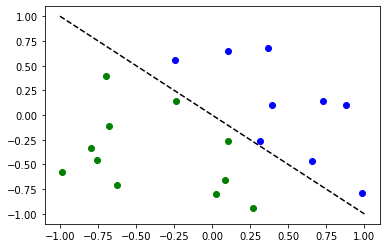

In [3]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

### Classification with the an `OpflowQNN`

First we show how an `OpflowQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `OpflowQNN` is expected to return one-dimensional output in $[-1, +1]$. This only works for binary classification and we assign the two classes to $\{-1, +1\}$. For convenience, we use the `TwoLayerQNN`, which is a special type of `OpflowQNN` defined via a feature map and a variational circuit.

In [4]:
# construct QNN
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [5]:
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X[0, :], np.random.rand(opflow_qnn.num_weights))

array([[-0.22439918]])

In [6]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=L_BFGS_B())

In [7]:
# fit classifier to data
opflow_classifier.fit(X, y)

# print results from fitting
print(opflow_classifier._fit_result)

(array([-0.1621492 ,  1.18967054, -0.55735613, -0.8575714 ,  1.45482108,
        1.0003222 , -0.36942704,  2.41734276]), 19.194618119449853, 28)


In [8]:
# score classifier
opflow_classifier.score(X, y)

0.6

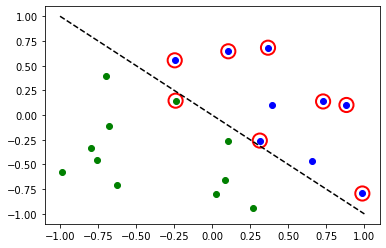

In [9]:
# evaluate data points
y_predict = opflow_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

### Classification with a `CircuitQNN`

Next we show how a `CircuitQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `CircuitQNN` is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes. Sampling from a `QuantumCircuit` automatically results in a probability distribution and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

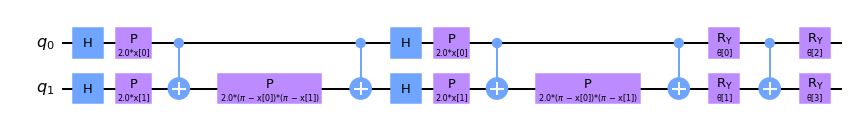

In [10]:
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct variational form
var_form = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(var_form, range(num_inputs))
qc.decompose().draw(output='mpl')

In [11]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return '{:b}'.format(x).count('1') % 2
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [12]:
# construct QNN
circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=var_form.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

In [13]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA())

In [14]:
# fit classifier to data
circuit_classifier.fit(X, y01)

# print results from fitting
print(circuit_classifier._fit_result)

(array([-0.27476144,  1.07186309,  1.08120295,  1.81094055]), 8.554857272130924, 197)


In [15]:
# score classifier
circuit_classifier.score(X, y01)

0.55

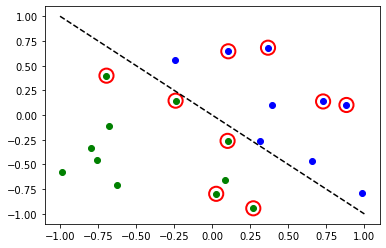

In [16]:
# evaluate data points
y_predict = circuit_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

### Variational Quantum Classifier (`VQC`)

The `VQC` is a special variant of the `NeuralNetworkClassifier` with a `CircuitQNN`. It applies a parity mapping (or extensions to multiple classes) to map from the bitstring to the classification, which results in a probability vector, which is interpreted as a one-hot encoded result. By default, it applies this the `CrossEntropyLoss` function that expects labels given in one-hot encoded format and will return predictions in that format too.

In [17]:
# construct feature map, variational form, and optimizer
feature_map = ZZFeatureMap(num_inputs)
var_form = RealAmplitudes(num_inputs, reps=1)
optimizer = L_BFGS_B()

# construct variational quantum classifier
vqc = VQC(feature_map=feature_map,
          var_form=var_form, 
          loss='cross_entropy',
          optimizer=optimizer, 
          quantum_instance=quantum_instance)

In [18]:
# fit classifier to data
vqc.fit(X, y_one_hot)

# print results from fitting
print(vqc._fit_result)

(array([0.06951704, 0.66552089, 0.97652809, 1.26919595]), 19.6119063820783, 53)


In [19]:
# score classifier
vqc.score(X, y_one_hot)

0.55

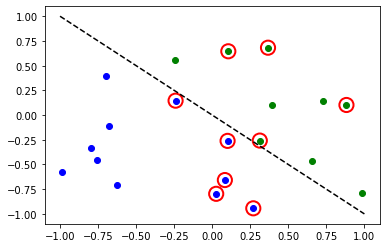

In [20]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

## Regression

We prepare a simple regression dataset to illustrate the following algorithms.

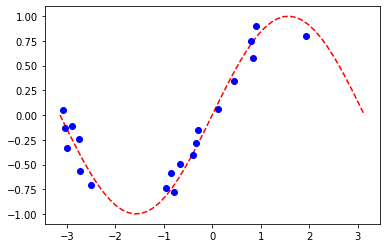

In [21]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb)*np.random.rand(num_samples, 1) + lb
y = f(X[:,0]) + eps*(2*np.random.rand(num_samples)-1)

plt.plot(X_, f(X_), 'r--')
plt.plot(X, y, 'bo')
plt.show()

### Regression with an `OpflowQNN`

Here we restrict to regression with an `OpflowQNN` that returns values in $[-1, +1]$. More complex and also multi-dimensional models could be constructed, also based on `CircuitQNN` but that exceeds the scope of this tutorial.

In [22]:
# construct simple feature map
param_x = Parameter('x')
feature_map = QuantumCircuit(1, name='fm')
feature_map.ry(param_x, 0)

# construct simple feature map
param_y = Parameter('y')
var_form = QuantumCircuit(1, name='vf')
var_form.ry(param_y, 0)

# construct QNN
regression_opflow_qnn = TwoLayerQNN(1, feature_map, var_form, quantum_instance=quantum_instance)

In [23]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(neural_network=regression_opflow_qnn, 
                                   loss='l2', 
                                   optimizer=L_BFGS_B())

In [24]:
# fit to data
regressor.fit(X, y)

# score the result
regressor.score(X, y)

0.9498745900608376

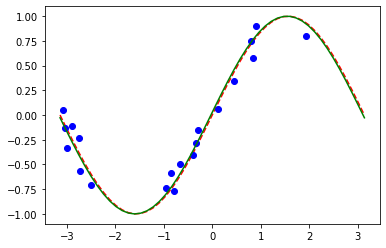

In [25]:
# plot target function
plt.plot(X_, f(X_), 'r--')

# plot data
plt.plot(X, y, 'bo')

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, 'g-')
plt.show()

### Regression with the Variational Quantum Regressor (`VQR`)

Similar to the `VQC` for classification, the `VQR` is a special variant of the `NeuralNetworkRegressor` with a `OpflowQNN`. By default it considers the `L2Loss` function to minimize the mean squared error between predictions and targets.

In [26]:
# show how VQR works (should use opflow qnn internally)